In [114]:
import os
import glob
import json
import datetime as dt
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

In [2]:
df_teams = sql.df_from_query("""
    SELECT * from teams
""")
df_teams.head()

,team_id,conference,location,year_start,year_end
0,abilene-christian,Southland,"Abilene, Texas",1971,2020
1,air-force,MWC,"USAF Academy, Colorado",1958,2020
2,akron,MAC,"Akron, Ohio",1902,2020
3,alabama-am,SWAC,"Normal, Alabama",2000,2020
4,alabama,SEC,"Tuscaloosa, Alabama",1913,2020


In [20]:
df_games = sql.df_from_query("""
    SELECT * from game_data
    """
)
print(df_games.shape)
df_games.head()

(54760, 39)


,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,13,-1,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,5,-1,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,-1,-1,...,17,22,13,16,11,27,18,1,31,98.36
3,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,-1,-1,...,10,18,5,21,8,16,5,5,24,80.44
4,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,-1,-1,...,16,19,10,25,12,22,8,8,19,77.64


In [40]:
df_reddit = sql.df_from_query("""
    SELECT date,gid,is_postgame,ups,num_comments from gamethreads
    """
)
print(df_reddit.shape)
df_reddit.head()

(14387, 5)


,date,gid,is_postgame,ups,num_comments
0,2017-11-10,2017-11-10_alabama-birmingham_jacksonville,True,9,0
1,2017-11-10,2017-11-10_alabama_memphis,False,6,81
2,2017-11-10,2017-11-10_albany-ny_iona,False,7,8
3,2017-11-10,2017-11-10_arizona_northern-arizona,False,13,82
4,2017-11-10,2017-11-10_austin-peay_vanderbilt,False,4,2


In [5]:
df_comments = sql.df_from_query("""
    SELECT gid,is_postgame,author,author_flair from gamethread_comments
""")
# df_comments.author_flair.head(20)
df_comments.author_flair = df_comments.author_flair.apply(lambda x: [x.strip('"') for x in x.strip('{}').split(',')])
print(df_comments.shape)
df_comments.head()

(387257, 4)


,gid,is_postgame,author,author_flair
0,2019-11-06_binghamton_cornell,True,CaffeinationGoat,"[Connecticut Huskies, Binghamton Bearcats]"
1,2019-11-06_binghamton_cornell,True,cheesoidhateself,[Cornell Big Red]
2,2019-11-06_binghamton_cornell,True,PAPA_JOHNS_ZIMBABWE,[NJIT Highlanders]
3,2019-11-06_binghamton_cornell,True,IsYouWitItYaBish,[Wisconsin Badgers]
4,2019-11-06_boston-college_wake-forest,False,mrfixit420,[Wake Forest Demon Deacons]


In [6]:
flairs = pd.Series([x for subl in df_comments.drop_duplicates('author').author_flair.values.tolist() for x in subl])
print(flairs.nunique())
flairs.value_counts().head(20)

591


                              5479
Michigan Wolverines            976
Michigan State Spartans        860
North Carolina Tar Heels       711
Kentucky Wildcats              685
Kansas Jayhawks                659
Purdue Boilermakers            561
Virginia Cavaliers             530
Duke Blue Devils               510
Indiana Hoosiers               449
Wisconsin Badgers              445
Maryland Terrapins             413
Illinois Fighting Illini       400
Tennessee Volunteers           389
NC State Wolfpack              379
Ohio State Buckeyes            373
Auburn Tigers                  348
Virginia Tech Hokies           346
Syracuse Orange                343
West Virginia Mountaineers     333
dtype: int64

In [7]:
team_ids = df_teams.team_id.values.tolist()
subs = json.load(open('../data/flair_substitutions.json'))
mapping = {}
for flair in flairs.value_counts().index:
    parts = flair.lower().replace('&','').replace('.','').replace("'",'').strip().split()
    for i in range(len(parts)):
        f = '-'.join(parts[:len(parts)-i])
        if f in team_ids and f not in mapping:
            mapping[f] = flair
            break
        if flair in subs and subs[flair] in team_ids and subs[flair] not in mapping:
            mapping[subs[flair]] = flair
            break
print(len(mapping))
pd.Series(flairs[~flairs.isin(mapping.values())]).value_counts().head(20)
# mapping

295


                              5479
Final Four                      50
Big East                        37
Big Ten                         30
Poll Veteran                    25
r                               20
CollegeBasketball               19
March Madness                   17
Big 12                          11
Bellarmine Knights              11
ACC                             11
NCAA                             9
American                         8
Atlantic 10                      7
Johns Hopkins Blue Jays          6
SEC                              6
UNC Wilmington Seahawks          6
UC Santa Cruz Banana Slugs       6
MIT Engineers                    6
SIUE Cougars                     6
dtype: int64

In [8]:
df_comments.author_flair.head()
flair_counts = {}
authors = df_comments.drop_duplicates('author')[['author','author_flair']]
for tid in mapping:
    flair_counts[tid] = authors.author_flair.apply(lambda x:mapping[tid] in x).sum()
for t,c in sorted(flair_counts.items(), key=lambda x:x[1], reverse=True)[:10]:
    print(f"{c:4d} {t}")

 976 michigan
 860 michigan-state
 711 north-carolina
 685 kentucky
 659 kansas
 561 purdue
 530 virginia
 510 duke
 449 indiana
 445 wisconsin


In [41]:
def get_nauthors(row):
    tid1, tid2 = row.gid.split('_')[1:]
    return flair_counts.get(tid1,5) + flair_counts.get(tid2,5)
df_reddit["nauthors"] = df_reddit.apply(get_nauthors, axis=1)
df_reddit["norm_num_comments"] = df_reddit.num_comments / np.sqrt(df_reddit.nauthors)
df_reddit.query('nauthors>1000 & num_comments<20')

,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments
3690,2018-02-06,2018-02-06_iowa_michigan-state,True,2,7,1176,0.204124
3698,2018-02-06,2018-02-06_michigan_northwestern,True,11,8,1048,0.247121
3929,2018-02-13,2018-02-13_auburn_kentucky,False,1,2,1033,0.062227
4510,2018-03-02,2018-03-02_michigan_nebraska,True,1,3,1163,0.087969
12353,2020-01-09,2020-01-09_north-carolina_north-carolina-state,True,21,10,1090,0.302891


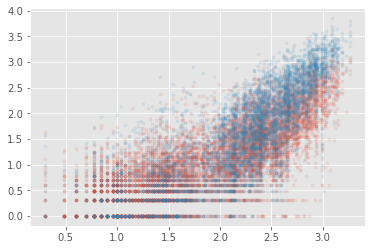

In [10]:
plt.figure()
plt.scatter(np.log10(df_reddit.nauthors[df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
plt.scatter(np.log10(df_reddit.nauthors[~df_reddit.is_postgame]), 
            np.log10(df_reddit.num_comments[~df_reddit.is_postgame]+1), 
            s=10, alpha=0.1)
# plt.gca().set_ylim(0,2000)

Text(0.5, 0, 'log10((#comments + 1) / sqrt(nauthors))')

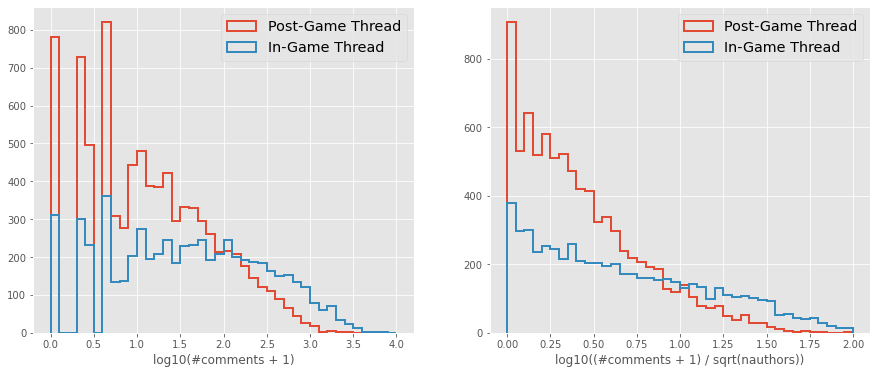

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(np.log10(df_reddit[df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="Post-Game Thread")
axs[0].hist(np.log10(df_reddit[~df_reddit.is_postgame].num_comments+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="In-Game Thread")
axs[0].legend(fontsize='x-large')
axs[0].set_xlabel("log10(#comments + 1)", fontsize='large')
axs[1].hist(np.log10(df_reddit[df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="Post-Game Thread")
axs[1].hist(np.log10(df_reddit[~df_reddit.is_postgame].norm_num_comments+1), bins=np.linspace(0,2,41), histtype='step', lw=2, label="In-Game Thread")
axs[1].legend(fontsize='x-large')
axs[1].set_xlabel("log10((#comments + 1) / sqrt(nauthors))", fontsize='large')

In [118]:
FRAC = 0.7
first, second = utils.partition_games(df_games, frac=FRAC)
print(df_games.iloc[first].shape[0], df_games.iloc[second].shape[0])

38328 16432


In [13]:
season_stats_dict = utils.compute_season_stats(df_games.iloc[first])
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
utils.add_advanced_stats(season_stats_df)
season_stats_dict = utils.stats_df_to_dict(season_stats_df)
print(season_stats_df.shape)
season_stats_df.head()

(3497, 54)


,year,team_id,wins,losses,totOT,TScore,TFGM,TFGA,TFGM3,TFGA3,...,Torbp,Tftr,Oposs,Oeff,Oastr,Otovr,Oefgp,Oorbp,Oftr,rawpace
0,2011,air-force,12,8,2,1328,463,941,133,333,...,0.196078,0.414453,1261.96,101.825731,0.157057,0.169381,0.485780,0.338073,0.283486,61.890370
1,2011,akron,12,10,2,1498,527,1263,175,508,...,0.262003,0.306413,1522.28,96.434296,0.137450,0.190418,0.480897,0.315789,0.383721,68.349663
2,2011,alabama,15,7,1,1493,566,1249,96,311,...,0.356601,0.293034,1502.48,83.595123,0.110456,0.199252,0.409393,0.300525,0.346633,67.763164
3,2011,alabama-am,6,10,0,959,348,896,62,237,...,0.282004,0.377232,1143.32,90.875695,0.136156,0.209393,0.472254,0.323194,0.399773,71.501250
4,2011,alabama-birmingham,16,6,5,1537,547,1224,166,480,...,0.312789,0.307190,1472.84,94.375492,0.130914,0.164221,0.457404,0.308123,0.287420,64.801768


In [15]:
eff.compute_efficiency_ratings(season_stats_dict)
season_stats_df = utils.stats_dict_to_df(season_stats_dict)
season_stats_df[["year","team_id","Tneteff","Tcorroeff","Tcorrdeff","rawpace","pace"]]\
    .query('year==2020')\
    .sort_values('Tneteff', ascending=False).reset_index(drop=True).head(10)

,year,team_id,Tneteff,Tcorroeff,Tcorrdeff,rawpace,pace
0,2020,kansas,34.641786,118.394295,83.752509,68.539645,68.775683
1,2020,duke,31.643722,116.392154,84.748432,73.079322,72.573887
2,2020,gonzaga,29.316181,120.454091,91.137910,73.529534,73.413686
3,2020,michigan-state,28.933219,114.867731,85.934512,70.425217,71.670500
4,2020,arizona,27.482542,114.415330,86.932789,71.549349,70.566941
5,2020,baylor,27.079817,110.356296,83.276478,67.893333,67.952735
6,2020,west-virginia,26.614793,110.020211,83.405417,70.822727,71.397619
7,2020,ohio-state,25.490115,112.229705,86.739590,67.676364,67.775695
8,2020,san-diego-state,25.352452,110.804406,85.451954,67.031818,66.828094
9,2020,dayton,24.638135,116.556766,91.918631,69.259441,69.623498


In [36]:
data = utils.compile_training_data(df_games.iloc[second], season_stats_dict, random_seed=1)
print(data.shape)
data.query("tid1=='purdue' | tid2=='purdue'").sample(frac=1, random_state=1).head(10)

(16432, 30)


,season,date,gid,tid1,tid2,result,rank1,rank2,totscore,margin,...,Tastr,Oastr,Oeff,Tftr,Oorbp,Torbp,Ttovr,neteffsum,Oefgp,Oftr
10692,2017,2017-02-25,2017-02-25_michigan_purdue,purdue,michigan,0,14,-1,152,-12,...,0.035118,0.008013,-9.570001,0.020341,-0.048833,0.056245,0.031144,48.465058,-0.060768,-0.056239
5532,2014,2014-02-23,2014-02-23_nebraska_purdue,nebraska,purdue,1,-1,-1,133,19,...,-0.018887,-0.002743,0.876905,0.098607,-0.043847,-0.105181,0.007118,17.951323,0.027760,0.054069
9669,2016,2016-03-12,2016-03-12_michigan_purdue,michigan,purdue,0,-1,13,135,-17,...,-0.007039,0.013620,10.919124,-0.055055,0.052403,-0.094658,-0.024098,48.327846,0.072586,-0.022938
12278,2018,2018-02-22,2018-02-22_illinois_purdue,illinois,purdue,0,-1,9,179,-7,...,-0.052952,-0.000115,7.746202,-0.017028,0.008262,0.067415,0.031345,46.043370,0.061853,0.215292
6167,2014,2014-03-09,2014-03-09_northwestern_purdue,northwestern,purdue,1,-1,-1,139,9,...,0.002910,0.008233,-4.616429,0.007175,-0.035408,-0.165682,0.012880,12.608481,-0.026544,-0.002722
9200,2016,2016-03-01,2016-03-01_nebraska_purdue,purdue,nebraska,1,15,-1,143,19,...,0.052912,-0.003474,-12.477338,0.008917,-0.062344,0.033286,0.004747,36.527861,-0.062140,-0.128684
9028,2016,2016-02-27,2016-02-27_maryland_purdue,maryland,purdue,0,10,20,162,-4,...,-0.022277,-0.012892,5.093022,0.016878,0.060298,-0.035513,0.015145,51.503470,0.018857,-0.006785
13586,2019,2019-02-19,2019-02-19_indiana_purdue,indiana,purdue,0,-1,15,94,-2,...,-0.014661,0.000954,-3.561095,0.054414,0.011251,-0.104259,0.027091,47.740220,-0.023140,-0.044120
4752,2013,2013-03-20,2013-03-20_purdue_western-illinois,purdue,western-illinois,1,-1,-1,148,14,...,0.008413,-0.005153,-0.198411,-0.046855,-0.023393,0.141213,-0.016247,12.692052,-0.024026,0.006509
9651,2016,2016-03-11,2016-03-11_illinois_purdue,purdue,illinois,1,13,-1,147,31,...,0.034749,-0.017714,-15.249778,-0.007900,-0.076218,0.152116,0.024638,31.209353,-0.098564,0.014907


In [71]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss, mean_absolute_error

pca = utils.get_pca_model()
logreg = LogisticRegression()
linreg = LinearRegression()

data_train, data_valid = utils.train_test_split_by_year(data, range(2011,2018), [2018,2019,2020], pca_model=pca)
PCAFEATURES = ['PCA'+str(i) for i in range(len(utils.ADVSTATFEATURES))]
X_train = data_train[PCAFEATURES+['HA']]
y_train = data_train.result
X_valid = data_valid[PCAFEATURES+['HA']]
y_valid = data_valid.result

logreg.fit(X_train, y_train)
predicted_probs = logreg.predict_proba(X_valid)[:,1].tolist()
score = np.exp(-log_loss(y_valid, predicted_probs))
print('logreg score:',score)
data_valid["pred_prob"] = predicted_probs

print("Regression for pace")
X_train = np.array([data_train.pace1*data_train.pace2]).T
X_valid = np.array([data_valid.pace1*data_valid.pace2]).T
linreg.fit(X_train, data_train.poss)
pred_pace_train = linreg.predict(X_train)
pred_pace_valid = linreg.predict(X_valid)
data_valid["pred_pace"] = pred_pace_valid
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X_valid, data_valid.poss))
print(mean_absolute_error(data_valid.poss,pred_pace_valid))

print("Regression for score margin")
X_train = np.array([pred_pace_train*data_train.effdiff, data_train.HA]).T
X_valid = np.array([pred_pace_valid*data_valid.effdiff, data_valid.HA]).T
linreg.fit(X_train, data_train.margin)
pred_margin_train = linreg.predict(X_train)
pred_margin_valid = linreg.predict(X_valid)
data_valid["pred_margin"] = pred_margin_valid
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X_valid, data_valid.margin))
print(mean_absolute_error(data_valid.margin,pred_margin_valid))

## Right now all values are relative to a randomly selected reference team
## To merge with the reddit data we need to change everything to be in reference to first team alphabetically
data_valid['prob_1stAlph'] = data_valid.apply(lambda row: row.pred_prob if row.tid1<row.tid2 else 1-row.pred_prob, axis=1)
data_valid['pred_margin_1stAlph'] = data_valid.apply(lambda row: row.pred_margin if row.tid1<row.tid2 else -row.pred_margin, axis=1)
data_valid['rank_1stAlph'] = data_valid.apply(lambda row: row.rank1 if row.tid1<row.tid2 else row.rank2, axis=1)
data_valid['rank_2ndAlph'] = data_valid.apply(lambda row: row.rank2 if row.tid1<row.tid2 else row.rank1, axis=1)
data_valid[['gid','tid1','tid2','result','pred_prob','pred_margin_1stAlph','pred_pace','prob_1stAlph', 'rank_1stAlph', 'rank_2ndAlph']] \
    .query("tid1=='purdue' | tid2=='purdue'").sort_values('pred_pace', ascending=False).head(10)

logreg score: 0.5674878611707846
Regression for pace
[0.01016406] 19.49254511409751
0.3593450944044443
3.435727299342778
Regression for score margin
[0.00863892 3.34900713] 0.051424715316670505
0.3056869541774174
8.73218643907749


,gid,tid1,tid2,result,pred_prob,pred_margin_1stAlph,pred_pace,prob_1stAlph,rank_1stAlph,rank_2ndAlph
12278,2018-02-22_illinois_purdue,illinois,purdue,0,0.227728,-11.137585,71.774500,0.227728,-1,9
12502,2018-02-25_minnesota_purdue,minnesota,purdue,0,0.060322,-18.536275,71.345413,0.060322,-1,9
13074,2018-03-16_cal-state-fullerton_purdue,cal-state-fullerton,purdue,0,0.032235,-21.360757,70.894719,0.032235,-1,10
12153,2018-02-18_penn-state_purdue,penn-state,purdue,0,0.106632,-14.413736,70.072618,0.106632,-1,6
12740,2018-03-03_penn-state_purdue,purdue,penn-state,1,0.818191,-11.167578,70.072618,0.181809,-1,8
13106,2018-03-18_butler_purdue,purdue,butler,1,0.753512,-9.091913,70.013746,0.246488,-1,10
13945,2019-02-27_illinois_purdue,illinois,purdue,0,0.093135,-14.178071,69.680823,0.093135,-1,14
11713,2018-02-10_michigan-state_purdue,michigan-state,purdue,1,0.597175,2.333449,69.076560,0.597175,4,3
12666,2018-03-02_purdue_rutgers,purdue,rutgers,1,0.924128,17.784408,68.906330,0.924128,8,-1
11563,2018-02-07_ohio-state_purdue,purdue,ohio-state,0,0.811398,-10.575867,68.862157,0.188602,14,3


In [73]:
merged = df_reddit.merge(data_valid[['gid','neteffsum','prob_1stAlph', 'pred_margin_1stAlph',
                                     'pred_pace','rank_1stAlph', 'rank_2ndAlph']], 
                            left_on='gid', right_on='gid', how='left')
merged.rename({'prob_1stAlph':'prob', 'pred_margin_1stAlph':'pred_margin',
               'rank_1stAlph':'rank1', 'rank_2ndAlph':'rank2'}, axis=1, inplace=True)
merged = merged.dropna()

def get_upset_prob(row):
    # somewhat arbitrarily define an upset as an unranked team 
    # beating a team ranked #20 or better, or a team beating
    # a team ranked at least 10 spots higher than itself
    if (row.rank1 < 0 and 0 < row.rank2 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank1-row.rank2 > 10):
        return row.prob
    if (row.rank2 < 0 and 0 < row.rank1 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank2-row.rank1 > 10):
        return 1-row.prob
    return 0.0

merged["upset_prob"] = merged.apply(get_upset_prob, axis=1)
merged["abs_pred_margin"] = merged.pred_margin.abs()

print(merged.shape)
merged.sort_values('upset_prob', ascending=False).head(10)

(4022, 15)


,date,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,neteffsum,prob,pred_margin,pred_pace,rank1,rank2,upset_prob,abs_pred_margin
8872,2019-02-27,2019-02-27_marquette_villanova,True,231,177,334,9.685009,43.314479,0.234205,-5.689952,66.912134,10.0,-1.0,0.765795,5.689952
8871,2019-02-27,2019-02-27_marquette_villanova,False,33,459,334,25.115363,43.314479,0.234205,-5.689952,66.912134,10.0,-1.0,0.765795,5.689952
13617,2020-02-15,2020-02-15_maryland_michigan-state,True,820,510,1273,14.294072,52.439471,0.280062,-6.671056,69.761189,9.0,-1.0,0.719938,6.671056
13616,2020-02-15,2020-02-15_maryland_michigan-state,False,89,1699,1273,47.618880,52.439471,0.280062,-6.671056,69.761189,9.0,-1.0,0.719938,6.671056
8355,2019-02-12,2019-02-12_kansas-state_texas,False,37,653,333,35.784180,36.834799,0.298439,-4.756369,64.622648,18.0,-1.0,0.701561,4.756369
8356,2019-02-12,2019-02-12_kansas-state_texas,True,224,205,333,11.233931,36.834799,0.298439,-4.756369,64.622648,18.0,-1.0,0.701561,4.756369
14250,2020-03-07,2020-03-07_baylor_west-virginia,False,39,529,464,24.558208,53.694610,0.314599,-3.021171,68.805125,4.0,-1.0,0.685401,3.021171
14251,2020-03-07,2020-03-07_baylor_west-virginia,True,804,312,464,14.484236,53.694610,0.314599,-3.021171,68.805125,4.0,-1.0,0.685401,3.021171
13883,2020-02-23,2020-02-23_maryland_ohio-state,True,923,515,786,18.369442,48.996367,0.318260,-4.446362,67.029430,7.0,25.0,0.681740,4.446362
13882,2020-02-23,2020-02-23_maryland_ohio-state,False,75,1669,786,59.531258,48.996367,0.318260,-4.446362,67.029430,7.0,25.0,0.681740,4.446362


0.5373294820022715
0.027984020568888584
0.3982936432213228
-0.05646199583598801


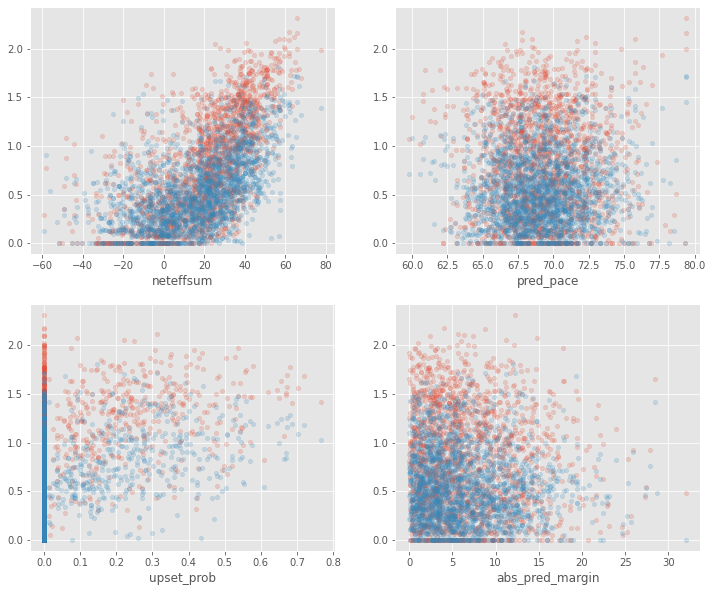

In [81]:
fig,axs = plt.subplots(2,2,figsize=(12,10))
axs = axs.flatten()
ip = merged.is_postgame
for i,var in enumerate(['neteffsum','pred_pace','upset_prob','abs_pred_margin']):
    axs[i].scatter(merged[~ip][var], np.log10(merged[~ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].scatter(merged[ ip][var], np.log10(merged[ ip].norm_num_comments+1), s=20, alpha=0.2)
    axs[i].set_xlabel(var)
    print(np.corrcoef(merged[ip][var], np.log10(merged[ip].norm_num_comments+1))[0,1])

In [96]:
merged.groupby('gid').mean().reset_index()

,gid,is_postgame,ups,num_comments,nauthors,norm_num_comments,neteffsum,prob,pred_margin,pred_pace,rank1,rank2,upset_prob,abs_pred_margin
0,2018-02-03_cincinnati_connecticut,0.5,56.5,191.0,426.0,9.253980,27.973153,0.893946,12.760002,66.958038,8.0,-1.0,0.106054,12.760002
1,2018-02-03_colorado-state_nevada,0.5,9.0,5.0,92.0,0.521286,18.821043,0.144819,-12.721607,70.820279,-1.0,-1.0,0.000000,12.721607
2,2018-02-04_arizona-state_washington-state,0.0,9.0,39.0,216.0,2.653614,22.028595,0.796324,8.414041,72.575100,25.0,-1.0,0.000000,8.414041
3,2018-02-04_boston-college_georgia-tech,0.5,6.5,12.5,124.0,1.122533,16.597397,0.742868,6.137259,67.329468,-1.0,-1.0,0.000000,6.137259
4,2018-02-04_illinois_ohio-state,0.5,66.0,216.5,773.0,7.786964,33.981686,0.175392,-10.248213,70.671454,-1.0,17.0,0.175392,10.248213
5,2018-02-04_iona_marist,1.0,6.0,4.0,11.0,1.206045,-11.254651,0.777889,8.386029,70.797803,-1.0,-1.0,0.000000,8.386029
6,2018-02-04_maryland_wisconsin,0.5,40.5,179.5,858.0,6.128029,27.686112,0.776482,8.965015,65.263594,-1.0,-1.0,0.000000,8.965015
7,2018-02-04_seton-hall_villanova,0.5,75.5,251.0,290.0,14.739228,56.905082,0.113968,-14.672135,71.154958,-1.0,1.0,0.113968,14.672135
8,2018-02-04_temple_tulane,0.5,8.0,10.5,68.0,1.273312,9.592225,0.473245,-0.977989,69.563351,-1.0,-1.0,0.000000,0.977989
9,2018-02-05_delaware-state_north-carolina-at,0.0,3.0,10.0,6.0,4.082483,-44.563764,0.071741,-16.557708,67.610448,-1.0,-1.0,0.000000,16.557708


[0.02739624 1.03044115 0.00124879] 0.9659945237169703


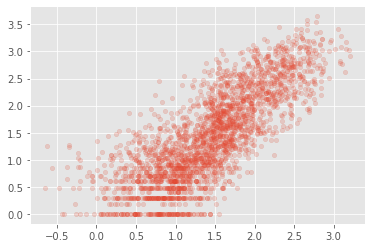

In [120]:
consol = merged.groupby('gid').mean().reset_index()
X = np.array([consol.neteffsum, consol.upset_prob, consol.abs_pred_margin]).T
y = np.log10(consol.num_comments + 1)
linreg.fit(X,y)
pred = linreg.predict(X)
print(linreg.coef_, linreg.intercept_)

consol["score"] = 10**(pred)-1

plt.figure()
plt.scatter(pred, y, s=20, alpha=0.2)

In [121]:
d1 = dt.date(2019,2,16)
d2 = dt.date(2019,2,23)
def between_dates(gid):
    date = dt.date(*[int(x) for x in gid.split('_')[0].split('-')])
    if d1 <= date and date < d2:
        return True
    return False

consol[['gid','num_comments','norm_num_comments','neteffsum','abs_pred_margin','upset_prob','score']] \
    .sort_values('score', ascending=False) \
    .loc[consol.gid.apply(between_dates)].head(20)

,gid,num_comments,norm_num_comments,neteffsum,abs_pred_margin,upset_prob,score
992,2019-02-18_virginia_virginia-tech,1049.0,35.442425,65.380653,2.249143,0.424003,1572.610953
1016,2019-02-20_duke_north-carolina,4476.5,128.109329,65.825747,12.222950,0.000000,608.027261
998,2019-02-19_clemson_florida-state,76.5,4.015209,39.933664,2.734779,0.609587,490.570548
986,2019-02-17_michigan-state_ohio-state,657.0,18.710433,53.359690,12.395499,0.178531,422.930244
934,2019-02-16_duke_north-carolina-state,764.5,25.640507,56.777461,17.870665,0.071472,413.427163
1000,2019-02-19_indiana_purdue,1781.5,56.056392,47.740220,2.923594,0.307734,392.232770
948,2019-02-16_kentucky_tennessee,2167.5,66.138900,59.202281,1.001840,0.000000,387.298564
952,2019-02-16_maryland_michigan,722.0,19.372518,49.545990,6.391025,0.231975,370.865827
1023,2019-02-20_louisville_syracuse,452.5,17.803374,40.345587,2.121257,0.428233,326.513999
929,2019-02-16_clemson_louisville,159.0,7.623466,44.438954,6.437674,0.289619,307.979635
